# Classifying skin cancer lessions using Convolutional Neural Network (CNN)

Author: Endrit Mustafa

## Importing libraries

In [13]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
import os

from PIL import Image
import concurrent.futures

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

import time
import shutil
import itertools
 
import cv2

from sklearn.utils import resample

## Dataframe Operations

In [4]:
# Reading the main_image_data.csv (Extracted by ImagesPreprocessing.ipynb)

df = pd.read_csv('../data/main_image_data.csv')

In [5]:
df.head()

,image_id,lesion_type,confirmation,age,sex,localization,path,subset,pixel_1,pixel_2,...,pixel_3063,pixel_3064,pixel_3065,pixel_3066,pixel_3067,pixel_3068,pixel_3069,pixel_3070,pixel_3071,pixel_3072
0,IMAGE_0000244,0,histo,80.0,male,scalp,../data/dataset/dataset/images\train\IMAGE_000...,train,191,152,...,136,176,131,146,184,149,169,184,153,176
1,IMAGE_0001916,0,histo,80.0,male,scalp,../data/dataset/dataset/images\train\IMAGE_000...,train,24,14,...,69,43,26,43,25,14,28,25,14,27
2,IMAGE_0006461,0,histo,80.0,male,scalp,../data/dataset/dataset/images\validation\IMAG...,validation,190,136,...,143,165,129,144,155,121,138,134,102,114
3,IMAGE_0003197,0,histo,80.0,male,scalp,../data/dataset/dataset/images\validation\IMAG...,validation,35,18,...,56,34,18,26,25,12,16,25,12,15
4,IMAGE_0009907,0,histo,75.0,male,ear,../data/dataset/dataset/images\train\IMAGE_000...,train,155,110,...,196,200,158,175,160,124,137,103,73,87


In [6]:
# Extracing the pixel columns as a NumPy array
pixel_columns = df[[f'pixel_{i+1}' for i in range(32*32*3)]].values

# Reshapeing the pixel columns to create the 'image' column
df['image'] = [pixels.reshape(32, 32, 3) for pixels in pixel_columns]

# Dropping the individual pixel columns
df.drop(columns=[f'pixel_{i+1}' for i in range(32*32*3)], inplace=True)

In [7]:
df.head()

,image_id,lesion_type,confirmation,age,sex,localization,path,subset,image
0,IMAGE_0000244,0,histo,80.0,male,scalp,../data/dataset/dataset/images\train\IMAGE_000...,train,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,IMAGE_0001916,0,histo,80.0,male,scalp,../data/dataset/dataset/images\train\IMAGE_000...,train,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,IMAGE_0006461,0,histo,80.0,male,scalp,../data/dataset/dataset/images\validation\IMAG...,validation,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,IMAGE_0003197,0,histo,80.0,male,scalp,../data/dataset/dataset/images\validation\IMAG...,validation,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,IMAGE_0009907,0,histo,75.0,male,ear,../data/dataset/dataset/images\train\IMAGE_000...,train,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."


### Showing some image samples to compare them visually

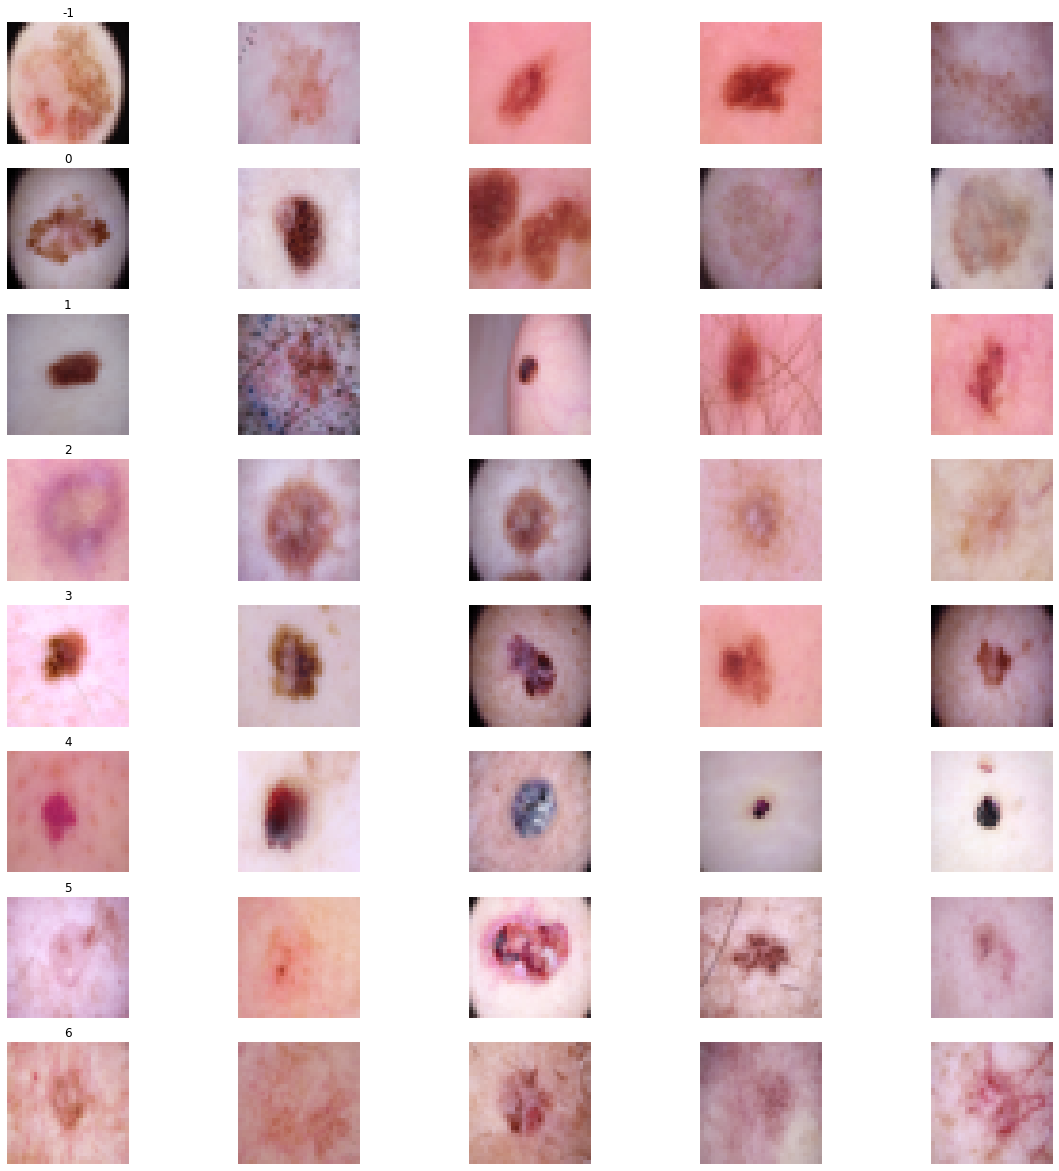

In [30]:
# Plotting random images from the samples we have

n_samples = 5  

# Plot
fig, m_axs = plt.subplots(8, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['lesion_type']).groupby('lesion_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


In [8]:
# Checking the amout of each category type

df['lesion_type'].value_counts()

 1    6029
 3    1006
-1    1000
 0     982
 5     473
 6     293
 4     124
 2     108
Name: lesion_type, dtype: int64

-1 Category is from test cases as seperated in dataset/images/test <br>

What we can see here aslo from the EDA notebook, we understand that our data is very much imbalanced. This could lead to a training model with not a correct accuracy. Based on the practices studied, for this cases it is better to resample the training data in more balanced ranges <br>

In this notebook, I will create a model by taking only image pixcels informations!

## Resampling the training data and spliting training / validation sets

In [9]:
# Copying the new df and storing it with a new instance name

df_new = df.copy()
df_new.head()

,image_id,lesion_type,confirmation,age,sex,localization,path,subset,image
0,IMAGE_0000244,0,histo,80.0,male,scalp,../data/dataset/dataset/images\train\IMAGE_000...,train,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,IMAGE_0001916,0,histo,80.0,male,scalp,../data/dataset/dataset/images\train\IMAGE_000...,train,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,IMAGE_0006461,0,histo,80.0,male,scalp,../data/dataset/dataset/images\validation\IMAG...,validation,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,IMAGE_0003197,0,histo,80.0,male,scalp,../data/dataset/dataset/images\validation\IMAG...,validation,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,IMAGE_0009907,0,histo,75.0,male,ear,../data/dataset/dataset/images\train\IMAGE_000...,train,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."


In [10]:
# Normalizing the Image Column

df_new['image'] = df_new['image'] / 255.0

In this assignment training, validation and testing samples were already splited in different folders in dataset.zip file. <br>
So to create the model we will use the same splits (train_test_split method will not be used)

In [11]:
# Creating a df with only training data (It will be used to resample training samples)

df_train = df_new[df_new['subset'] == 'train'][['lesion_type','image']]
df_train.shape

(8515, 2)

In [12]:
# Knowing that 'lesion_type' values 0 to 5 are the 6 minority classes
minority_class_values = [0, 2, 3, 4, 5, 6]

# Spliting majority and minority classes
df_majority = df_train[~df_train['lesion_type'].isin(minority_class_values)]

df_minority_list = [df_train[df_train['lesion_type'] == class_value] for class_value in minority_class_values]

In [14]:
# Defining the number of samples than minority clases should resample
n_samples = 800

# Distribution of data into various classes 
df_minority_oversampled_list = []
for df_minority in df_minority_list:
    df_minority_oversampled = resample(df_minority, replace=True, n_samples=n_samples, random_state=42)
    df_minority_oversampled_list.append(df_minority_oversampled)

In [15]:
# Concating oversampled minority classes df with the majority classes df

df_oversampled = pd.concat([df_majority] + df_minority_oversampled_list)

df_oversampled.shape

(10482, 2)

In [16]:
# Shuffling the df_oversampled dataframe
df_oversampled = df_oversampled.sample(frac=1, random_state=42)

df_oversampled.shape

(10482, 2)

In [17]:
# Converting lesion_type column to a categorical class by spliting it in diffrent columns

df_oversampled_dummies = pd.get_dummies(df_oversampled, columns=['lesion_type'])

In [18]:
# Separateing the features and target variables for training set

X_train = df_oversampled_dummies['image']

X_train = np.array(X_train.tolist())

y_train = df_oversampled_dummies.drop(columns=['image'])

X_train.shape, y_train.shape

((10482, 32, 32, 3), (10482, 7))

In [20]:
# Creating a df with only validation data

df_val = df_new.loc[df_new['subset'] == 'validation']
df_val_dummies = pd.get_dummies(df_val, columns=['lesion_type'])

In [21]:
# Separateing the features and target variables for validation set

X_val = df_val_dummies['image']

X_val = np.array(X_val.tolist())

y_val = df_val_dummies.drop(columns=['image_id','confirmation','age','sex','localization','path', 'subset', 'image'])

X_val.shape, y_val.shape

((500, 32, 32, 3), (500, 7))

In [22]:
# Rechecking the training and validation sets, before creating the model

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((10482, 32, 32, 3), (10482, 7), (500, 32, 32, 3), (500, 7))

## Creating the Model

### Forming the model layers

In [43]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [44]:
model = keras.models.Sequential()

# Createing Model Structure
model.add(keras.layers.Input(shape=[32, 32, 3]))

# Convolutional layer: Applies 32 filters of size 3x3 to the input, followed by the ReLU activation function, padding='same', and kernel_initializer='he_normal'.
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

# Two more Convolutional layers with 64 filters each, ReLU activation, padding='same', and kernel_initializer='he_normal'.
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

# Two more Convolutional layers with 128 filters each, ReLU activation, padding='same', and kernel_initializer='he_normal'.
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

# Two more Convolutional layers with 256 filters each, ReLU activation, padding='same', and kernel_initializer='he_normal'.
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

# Flattening the output from the convolutional layers into a 1D vector, preparing it for the fully connected layers.
model.add(keras.layers.Flatten())

# Regularization by randomly setting a fraction of inputs to 0 during training to reduce overfitting.
model.add(keras.layers.Dropout(rate=0.2))

# Dense layer with 256 units, ReLU activation, and kernel_initializer='he_normal'.
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

# Dense layer with 128 units, ReLU activation, and kernel_initializer='he_normal'.
model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

# Dense layer with 64 units, ReLU activation, and kernel_initializer='he_normal'.
model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

# Dense layer with 32 units, ReLU activation, kernel_initializer='he_normal', and kernel_regularizer=keras.regularizers.L1L2() - To prevent overfitting
model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

# Dense output layer with 7 units (number of classes), softmax activation, and kernel_initializer='glorot_uniform'.
# Softmax activation is used for multi-class classification problems.
model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

# Model compilation:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

# Printing the model summary, showing the layer structure and the number of parameters.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0

### Fitting the model

In [45]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=25 ,
                    batch_size=100,
                    validation_data=(X_val , y_val) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/25
105/105 [==============================] - 43s 390ms/step - loss: 1.5373 - accuracy: 0.4759 - val_loss: 2.1206 - val_accuracy: 0.2560 - lr: 0.0010
Epoch 2/25
105/105 [==============================] - 46s 440ms/step - loss: 1.0237 - accuracy: 0.6741 - val_loss: 3.1374 - val_accuracy: 0.0860 - lr: 0.0010
Epoch 3/25
105/105 [==============================] - 51s 486ms/step - loss: 0.7614 - accuracy: 0.7627 - val_loss: 1.3434 - val_accuracy: 0.5940 - lr: 0.0010
Epoch 4/25
105/105 [==============================] - 49s 471ms/step - loss: 0.6160 - accuracy: 0.8050 - val_loss: 1.0056 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 5/25
105/105 [==============================] - 54s 512ms/step - loss: 0.4816 - accuracy: 0.8497 - val_loss: 0.7306 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/25
105/105 [==============================] - 46s 440ms/step - loss: 0.4088 - accuracy: 0.8747 - val_loss: 0.8631 - val_accuracy: 0.7360 - lr: 0.0010
Epoch 7/25
105/105 [==============================] 

### Evaluating the model

In [46]:
# Evaluating the model on the test set

loss, accuracy = model.evaluate(X_val, y_val)
print("Test accuracy:", accuracy)

16/16 [==============================] - 1s 19ms/step - loss: 0.9282 - accuracy: 0.7680
Test accuracy: 0.7680000066757202


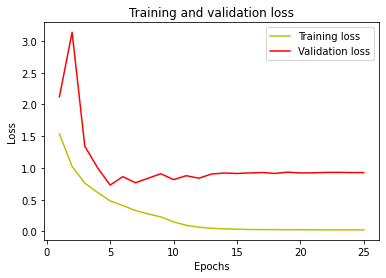

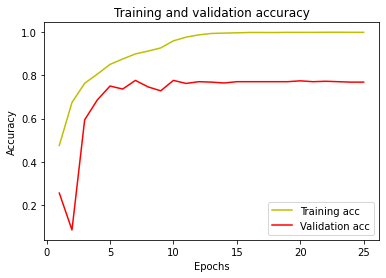

In [47]:
#ploting the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

16/16 [==============================] - 0s 22ms/step


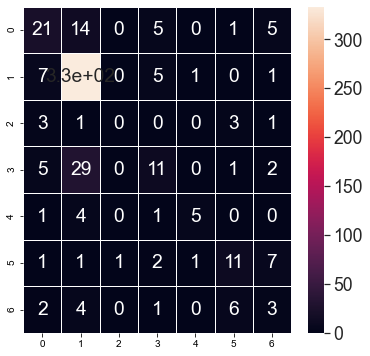

In [48]:
# Predicting on validation set 
y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 

# Convert validation set classes to one hot vectors
y_true = np.argmax(y_val.values, axis = 1) 

#Printing the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
plt.show()

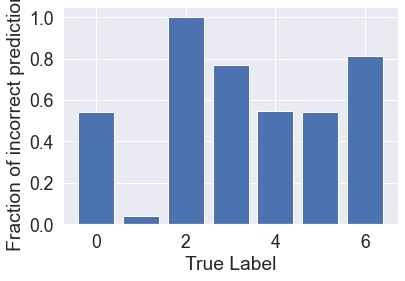

In [49]:
#PLotting fractional incorrect misclassifications

incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

plt.show()

Comment: <br>

The model is able to predict different classes in a reasonable accuracy rate. However in the validation part the bigest problem is with lesion_type = 2 cases. This is more because there are only a few cases in this group in the validation set. Moreover, it is better to try changing the model layers, as well as trying the model with higher image pixcels, in order to have a potentially more robust classifying model! 

### Saving the model

In [50]:
# Save the model to an HDF5 file

model.save("classifying_model_v3.h5")